<a href="https://colab.research.google.com/github/Jaeljane/cab/blob/main/Insight_for_Cab_Investment_firm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
#read the data
cab=pd.read_csv('/content/Cab_Data.csv')
Customer_id=pd.read_csv('/content/Customer_ID.csv')
Transaction_ID=pd.read_csv("/content/Transaction_ID.csv")
url='https://raw.githubusercontent.com/DataGlacier/DataSets/main/City.csv'
city=pd.read_csv(url,index_col=0)


In [3]:
#merge data
Customer_Tran= pd.merge(Transaction_ID, Customer_id)
data = pd.merge(cab, Customer_Tran)
#add city data to the main data
df= pd.merge(data, city, on='City')
df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,08-01-2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,"814,885","24,701"
1,10000012,06-01-2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,"814,885","24,701"
2,10000013,02-01-2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,"814,885","24,701"
3,10000014,07-01-2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,"814,885","24,701"
4,10000015,03-01-2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,"814,885","24,701"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246216 entries, 0 to 246215
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Transaction ID      246216 non-null  int64         
 1   Date of Travel      246216 non-null  datetime64[ns]
 2   Company             246216 non-null  object        
 3   City                246216 non-null  object        
 4   KM Travelled        246216 non-null  float64       
 5   Price Charged       246216 non-null  float64       
 6   Cost of Trip        246215 non-null  float64       
 7   Customer ID         246216 non-null  int64         
 8   Payment_Mode        246216 non-null  object        
 9   Gender              246216 non-null  object        
 10  Age                 246216 non-null  int64         
 11  Income (USD/Month)  246216 non-null  int64         
 12  Users               246216 non-null  float64       
 13  Year                246216 no

In [4]:
#Changing date of travel data type
df['Date of Travel']= pd.to_datetime(df['Date of Travel'])
#Create month and year column 
df['Year'] = pd.DatetimeIndex(df['Date of Travel']).year
df['Month'] = pd.DatetimeIndex(df['Date of Travel']).month

# Calculating profit
df['Profit'] = df['Price Charged'] - df['Cost of Trip']

#Average profit per km
df['Ave_Profit-per_km']=df['Profit']/df['KM Travelled']

#Extract dat of the week
df['Day_of_week'] = df['Date of Travel'].dt.day_name()
#Drop population column
df.drop(columns=['Population'], inplace=True)

#remove commas from users column
df['Users']=df['Users'].str.replace(",", "", regex=False).astype(float)

df.head()


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Users,Year,Month,Profit,Ave_Profit-per_km,Day_of_week
0,10000011,2016-08-01,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,24701.0,2016,8,57.315,1.882266,Monday
1,10000012,2016-06-01,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,24701.0,2016,6,23.666,0.826904,Wednesday
2,10000013,2016-02-01,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,24701.0,2016,2,27.568,3.049558,Monday
3,10000014,2016-07-01,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,24701.0,2016,7,25.798,0.777751,Friday
4,10000015,2016-03-01,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,24701.0,2016,3,16.844,1.929439,Tuesday


In [ ]:
from google.colab import files
df.to_csv('Master_data.csv') 
files.download('Master_data.csv')

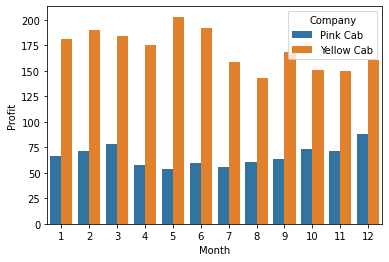

In [5]:
sns.barplot(x="Month", y="Profit", hue="Company", data=df,
            hue_order = ["Pink Cab", "Yellow Cab"], ci=None);

In [6]:
# New vs Existing Users
df_first_Travel=df.groupby(["Customer ID"])["Date of Travel"].min().reset_index()
df_first_Travel.columns=["Customer ID", "FirstTravelDate"]
df=pd.merge(df, df_first_Travel, on="Customer ID")
df["UserType"]="New"
df.loc[df["Date of Travel"]>df["FirstTravelDate"], "UserType"]="Existing"

df.head()



,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Users,Year,Month,Profit,Ave_Profit-per_km,Day_of_week,FirstTravelDate,UserType
0,10000011,2016-08-01,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,24701.0,2016,8,57.3150,1.882266,Monday,2016-08-01,New
1,10000012,2016-06-01,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,24701.0,2016,6,23.6660,0.826904,Wednesday,2016-06-01,New
2,10000013,2016-02-01,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242,24701.0,2016,2,27.5680,3.049558,Monday,2016-02-01,New
3,10079404,2016-09-21,Yellow Cab,ATLANTA GA,39.60,704.30,494.2080,28712,Card,Male,53,11242,24701.0,2016,9,210.0920,5.305354,Wednesday,2016-02-01,Existing
4,10186994,2017-06-23,Yellow Cab,ATLANTA GA,18.19,365.63,246.6564,28712,Card,Male,53,11242,24701.0,2017,6,118.9736,6.540605,Friday,2016-02-01,Existing


In [ ]:
df.to_csv('NewvsExisting.csv') 
files.download('NewvsExisting.csv')

<Figure size 432x288 with 0 Axes>

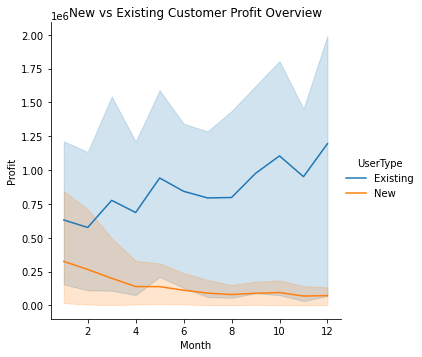

In [7]:
# New vs Existing User Revenue Analysis
df_new_Profit=df.groupby(["Month", "Year", "UserType"])["Profit"].sum().reset_index()
fig_dims=(6,6)
plt.figure()
sns.relplot(x="Month", y="Profit", hue="UserType", data=df_new_Profit, kind="line")
plt.title("New vs Existing Customer Profit Overview")
plt.xlabel("Month")
plt.ylabel("Profit");

In [8]:
# Recency Calculation
df_user=pd.DataFrame(df["Customer ID"].unique())
df_user.columns=["Customer ID"]
df_last_travel=df.groupby(["Customer ID"])["Date of Travel", "Company"].max().reset_index()
df_last_travel.columns=["Customer ID", "LastTravelDate","Company"]
df_last_travel["Recency"]= (df_last_travel["LastTravelDate"].max()-df_last_travel["LastTravelDate"]).dt.days
df_recency=pd.merge(df_user, df_last_travel[["Customer ID", "Recency", "Company"]])
df_recency.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Customer ID,Recency,Company
0,29290,853,Pink Cab
1,27703,914,Pink Cab
2,28712,527,Yellow Cab
3,28020,674,Yellow Cab
4,27182,323,Yellow Cab


<Figure size 1080x720 with 0 Axes>

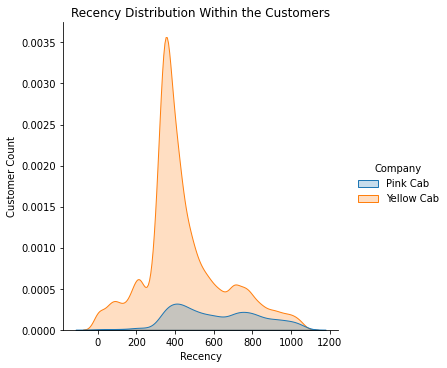

In [9]:
# Look at the distribution of Recency
plt.figure(figsize=(15,10))
#sns.distplot(df_recency["Recency"], hue="Company")
sns.displot(df_recency, x="Recency", hue="Company", kind="kde", fill=True)
plt.title("Recency Distribution Within the Customers")
plt.xlabel("Recency")
plt.ylabel("Customer Count");

In [ ]:
df_recency.to_csv('Recency') 
files.download('NewvsExisting.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# frequency of orders
df_frequency=df.groupby(["Company", "Customer ID"])["Date of Travel"].count().reset_index()
df_frequency.columns=["Company", "Customer ID", "Frequency"]
df_frequency=pd.merge(df_user, df_frequency, on="Customer ID")
df_frequency.head()

,Customer ID,Company,Frequency
0,29290,Pink Cab,1
1,27703,Pink Cab,1
2,28712,Pink Cab,1
3,28712,Yellow Cab,2
4,28020,Pink Cab,2


In [ ]:
df_frequency.to_csv('frequency.csv') 
files.download('frequency.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(8.750208333333333, 0.5, 'Count')

<Figure size 504x360 with 0 Axes>

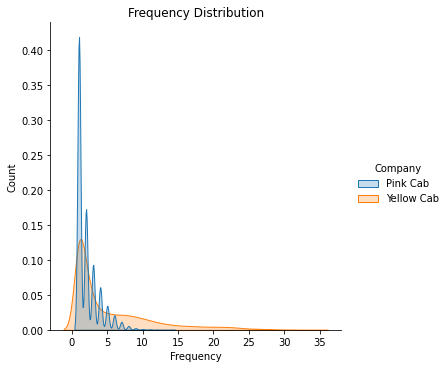

In [11]:
# Review of Frequency Distribution
plt.figure(figsize=(7,5))
#sns.distplot(df_frequency, x="Frequency", hue="Company")
sns.displot(df_frequency, x="Frequency", hue="Company", kind="kde", fill=True)
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")

In [12]:
fig = px.histogram(df_frequency, x="Frequency", color="Company", title="Frequency Distribution")
fig.show()

In [13]:
df_customer_revenue=df.groupby(["Company", "Customer ID"])["Profit"].sum().reset_index()
df_customer_revenue=pd.merge(df_user, df_customer_revenue, on="Customer ID")
df_customer_revenue.head()


,Customer ID,Company,Profit
0,29290,Pink Cab,57.3150
1,27703,Pink Cab,23.6660
2,28712,Pink Cab,27.5680
3,28712,Yellow Cab,329.0656
4,28020,Pink Cab,63.0900


In [ ]:
# Revenue Distribution
plt.figure(figsize=(15,10))
#sns.distplot(df_customer_revenue.query("Profit < 10000")["Profit"])
#sns.displot(df_customer_revenue, x="Profit", hue="Company", kind="kde", fill=True);
fig = px.histogram(df_customer_revenue, x="Profit", color="Company", title="Profit Distribution")
fig.show()

<Figure size 1080x720 with 0 Axes>

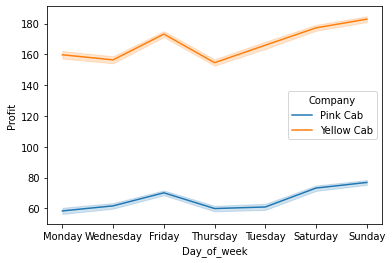

In [14]:
#Peak days that people hail Cabs
days = [day for day, df in df.groupby('Day_of_week')]
#plt.plot(days, df.groupby(['Day_of_week']).count());
sns.lineplot(data=df, x="Day_of_week", y="Profit", hue="Company");

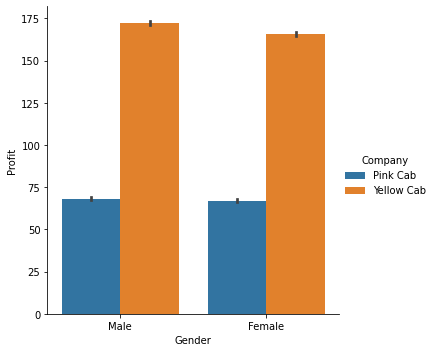

In [15]:
#customer segmentation
sns.catplot(x="Gender", y="Profit", hue="Company", kind="bar", data=df);

In [17]:
US_hol=pd.read_csv("/content/US Holiday Dates (2004-2021).csv")
US_hol.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [ ]:
from google.colab import files
data.to_csv('Holiday.csv') 
files.download('Holiday.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>